<a href="https://colab.research.google.com/github/Abs-CV/CV-Projects/blob/main/Image_Inpainting_With_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import zipfile
with zipfile.ZipFile("/content/gdrive/MyDrive/img_align_celeba.zip","r") as zip_ref:
    zip_ref.extractall("/content/")

## Imports

In [26]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

(218, 178, 3)


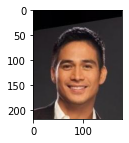

In [27]:
plt.figure(figsize=(2,2))
ig = cv2.imread('/content/img_align_celeba/000012.jpg')
print(ig.shape)
igg=cv2.cvtColor(ig, cv2.COLOR_BGR2RGB)
plt.imshow(igg)

In [28]:
os.cpu_count()

2

In [29]:
# Set number of epochs
n_epochs = 1

# Set batch size
batch_size = 16

# Set path of the dataset
dataset_name = "/content/img_align_celeba"

# Set learning rate for Adam optimizer
lr = 0.00008

# Set decay rate for first order momentum of gradient for Adam optimizer
b1 = 0.5

# Set decay rate for second order momentum of gradient for Adam optimizer
b2 = 0.999

# Set number of CPU threads to use during batch generation
n_cpu = 2

# Set size of each image dimension
img_size = 128

# Set size of random mask
mask_size = 64

# Set number of image channels
channels = 3

# Set interval between image sampling
sample_interval = 500

In [30]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, img_size=128, mask_size=64, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = sorted(glob.glob("%s/*.jpg" % root))
        self.files = self.files[:-4000] if mode == "train" else self.files[-4000:]

    def apply_random_mask(self, img):
        """Randomly masks image"""
#         print(img.shape)
        y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
        y2, x2 = y1 + self.mask_size, x1 + self.mask_size
        masked_part = img[:, y1:y2, x1:x2]
        masked_img = img.clone()
        masked_img[:, y1:y2, x1:x2] = 1

        return masked_img, masked_part

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        i = (self.img_size - self.mask_size) // 2
        masked_img = img.clone()
        masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1

        return masked_img, i

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        img = self.transform(img)
        if self.mode == "train":
            # For training data perform random mask
            masked_img, aux = self.apply_random_mask(img)
        else:
            # For test data mask the center of the image
            masked_img, aux = self.apply_center_mask(img)

        return img, masked_img, aux

    def __len__(self):
        return len(self.files)

In [31]:
# Define transformations for the dataset
transforms_ = [
    transforms.Resize((img_size, img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# Create training dataloader
dataloader = DataLoader(
    ImageDataset(dataset_name, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

# Create validation dataloader
test_dataloader = DataLoader(
    ImageDataset(dataset_name, transforms_=transforms_, mode="val"),
    batch_size=12,
    shuffle=True,
    num_workers=1,
)


In [32]:
img, masked_imgs, aux = next(iter(dataloader))
img.shape, masked_imgs.shape, aux.shape

(torch.Size([16, 3, 128, 128]),
 torch.Size([16, 3, 128, 128]),
 torch.Size([16, 3, 64, 64]))

In [33]:
def vis(idx):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15,10)
    a = img[idx].cpu().detach().numpy()
    a = np.transpose(a, (1, 2, 0))
    ax[0].imshow(a)
    ax[0].set_title("The Original Image")
    ax[1].imshow(np.transpose(masked_imgs[idx], (1, 2, 0)))
    ax[1].set_title("The masked Image")
    ax[2].imshow(np.transpose(aux[idx], (1, 2, 0)))
    ax[2].set_title("Mask Image")

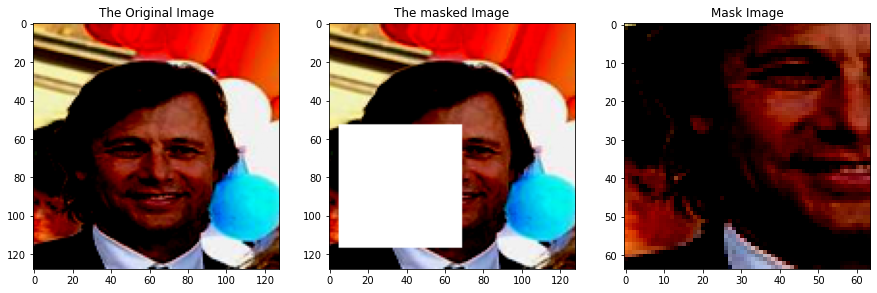

In [34]:
vis(10)

In [35]:
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 4000, 1),
            
            nn.ConvTranspose2d(4000, 512, 4, stride=2, padding=1), #upsample 
            nn.BatchNorm2d(512, 0.8),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), #upsample 
            nn.BatchNorm2d(256, 0.8),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), #upsample 
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), #upsample 
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

    
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 3, 1, 1)
        )
        

    def forward(self, img):
        return self.model(img)

In [36]:
cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)


patch_h, patch_w = int(mask_size / 2 ** 3), int(mask_size / 2 ** 3)
patch = (1, patch_h, patch_w)

In [37]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def save_sample(batches_done):
    samples, masked_samples, i = next(iter(test_dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    i = i[0].item()  # Upper-left coordinate of mask
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, i : i + mask_size, i : i + mask_size] = gen_mask
    # Save sample
    sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    save_image(sample, "images/%d.png" % batches_done, nrow=6, normalize=True)

    
# Loss function
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Initialize generator and discriminator
generator = Generator(channels=channels)
discriminator = Discriminator(channels=channels)

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [38]:
print(generator)

Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(512, 4000, kernel_si

In [39]:
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


In [40]:
gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []

for epoch in range(5):
    
    ### Training ###
    gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
    tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    for i, (imgs, masked_imgs, masked_parts) in enumerate(tqdm_bar):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)

        # Configure input
        imgs = Variable(imgs.type(Tensor))
        masked_imgs = Variable(masked_imgs.type(Tensor))
        masked_parts = Variable(masked_parts.type(Tensor))

        ## Train Generator ##
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_parts = generator(masked_imgs)

        # Adversarial and pixelwise loss
        g_adv = adversarial_loss(discriminator(gen_parts), valid)
        g_pixel = pixelwise_loss(gen_parts, masked_parts)
        # Total loss
        g_loss = 0.001 * g_adv + 0.999 * g_pixel

        g_loss.backward()
        optimizer_G.step()

        ## Train Discriminator ##
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(masked_parts), valid)
        fake_loss = adversarial_loss(discriminator(gen_parts.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        
        gen_adv_loss, gen_pixel_loss, disc_loss
        gen_adv_losses, gen_pixel_losses, disc_losses, counter
        
        gen_adv_loss += g_adv.item()
        gen_pixel_loss += g_pixel.item()
        gen_adv_losses.append(g_adv.item())
        gen_pixel_losses.append(g_pixel.item())
        disc_loss += d_loss.item()
        disc_losses.append(d_loss.item())
        counter.append(i*batch_size + imgs.size(0) + epoch*len(dataloader.dataset))
        tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1))
        
        # Generate sample at sample interval
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_sample(batches_done)
            
    torch.save(generator.state_dict(), "working/saved_models/generator.pth")
    torch.save(discriminator.state_dict(), "working/saved_models/discriminator.pth")

Training Epoch 0 :   0%|          | 0/12413 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/12413 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/12413 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [41]:
img, masked_imgs, aux = next(iter(test_dataloader))
g = generator(masked_imgs.type(Tensor))


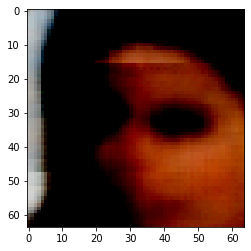

In [42]:
img_temp = g.cpu().detach().numpy()
img_temp = np.transpose(img_temp[0], (1, 2, 0))
plt.imshow(img_temp)

In [43]:
def vis(idx):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15,10)
    a = img[idx].cpu().detach().numpy()
    a = np.transpose(a, (1, 2, 0))
    ax[0].imshow(a)
    ax[0].set_title("The Original Image")
    ax[1].imshow(np.transpose(masked_imgs[0], (1, 2, 0)))
    ax[1].set_title("The masked Image")
    img_temp = g.cpu().detach().numpy()
    ax[2].imshow(np.transpose(img_temp[idx], (1, 2, 0)))
    ax[2].set_title("The predict Image")

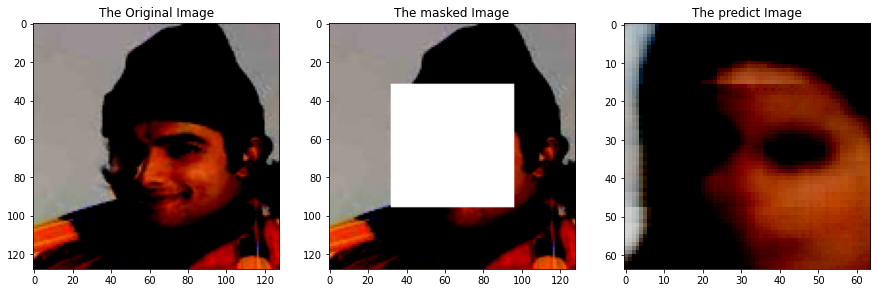

In [44]:
vis(0)